In [126]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as plt
import matplotlib.pyplot as plt
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [127]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [128]:
from tensorflow import keras
model = keras.models.load_model('./xray_model.h5')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [129]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [130]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [131]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [139]:
test_list_ds = tf.data.Dataset.list_files(str('./chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [154]:
pred_input = tf.data.Dataset.list_files(str('./Pneumocystis_pneumonia_high_vi.jpg'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(pred_input).numpy()
pred = pred_input.map(process_path, num_parallel_calls=AUTOTUNE)
pred = pred.batch(BATCH_SIZE)

In [140]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 5s 131ms/step - loss: 1.0333 - accuracy: 0.7869 - precision: 0.7466 - recall: 0.9974


In [155]:
y_pred = model.predict_classes(pred)
y_pred

array([[1]], dtype=int32)

In [160]:
image_batch, label_batch = next(iter(pred))

In [156]:
def show_batch(image_batch, pred):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n + 1)
        plt.imshow(image_batch[n])
        if pred == [[1]]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

IndexError: index 1 is out of bounds for axis 0 with size 1

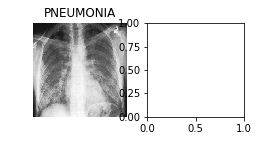

In [161]:
show_batch(image_batch.numpy(), y_pred)